# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
fileName = '../build/calibration.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)
print('df_hits length:', len(df_hits))

df_hits length: 4630


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)
print('df_primary length:', len(df_primary))

df_primary length: 1113217


# Filter Hits

In [7]:
search_radius = 1
search_number = 2

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Basic Hit Reco

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)

  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [00:00<00:00, 66209.64it/s]


# Make Grid

In [9]:
grid, grid_ind, grid_pos = get_voxelGrid(
    (30, 30, 30),
    DETECTOR_SIZE_MM,
    np.array(df_hits['sensor_position'].to_list()).reshape(-1,3),
    np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1,3),
    [1 for i in range(len(df_hits))],
    20,
    True
)

100%|██████████| 86/86 [00:44<00:00,  1.94it/s]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_48588/3966560590.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


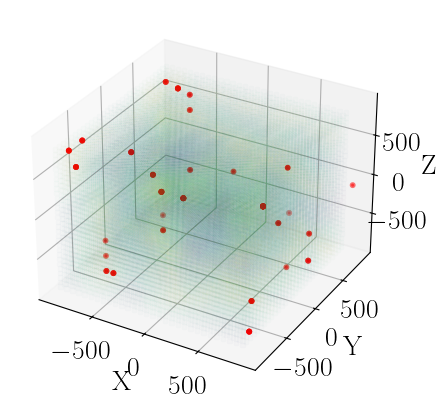

In [10]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track = ax.scatter(np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,0],
                   np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,1],
                   np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,2],
                   c='r',
                   marker='o',
                   s=5,
                   linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

# Mean Slice Reconstruction

In [11]:
df_hits = make_reconstructedVertex(df_hits, get_voxelGrid, (30, 30, 30), DETECTOR_SIZE_MM, True)

df_hits["initialPosition"].shape (86,)
np.ones(df_hits["initialPosition"].shape) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  3%|▎         | 1/29 [00:01<00:45,  1.61s/it]

np.argwhere(inds == True): [[51]
 [52]
 [53]]
recoVertex[inds]: [1. 1. 1.]
assignment: [-815.06496269 -720.88852403  568.28927567]


 10%|█         | 3/29 [00:04<00:40,  1.55s/it]

np.argwhere(inds == True): [[48]
 [49]
 [64]]
recoVertex[inds]: [1. 1. 1.]
assignment: [-727.33125082 -633.03319904  748.4689404 ]


 14%|█▍        | 4/29 [00:06<00:42,  1.70s/it]


np.argwhere(inds == True): [[11]]
recoVertex[inds]: [1.]
assignment: [-641.61691982 -516.04704887  -17.46243027]


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 1 output values where the mask is true

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_43022/1324957959.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


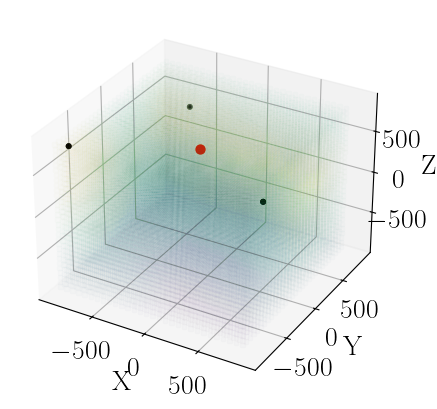

In [ ]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track_true = ax.scatter(np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,0],
                        np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,1],
                        np.array(df_hits['initialPosition'].to_list()).reshape(-1,3)[:,2],
                        c='black',
                        marker='o',
                        s=5,
                        linewidth=2)
track_avg = ax.scatter(pos_avg[0],
                       pos_avg[1],
                       pos_avg[2],
                       c='r',
                       marker='o',
                       s=30,
                       linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# ax.legend()
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_43022/3282736827.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


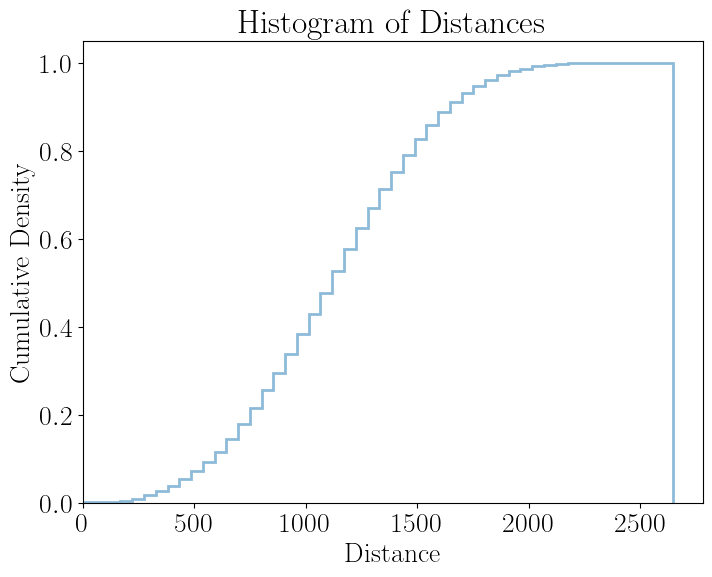

In [ ]:
# %matplotlib inline

true = np.array(df_primary['position'].to_list()).reshape(-1,3)
distances = cdist(true, np.reshape(pos_avg, (1,3)))
distances = np.min(distances, axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
cum = True
ax.hist(distances, bins=50, alpha=0.5, label='avg', histtype='step', cumulative=cum, density=True, linewidth=2)
ax.set_xlabel('Distance')
ax.set_ylabel('Cumulative Density')
ax.set_title('Histogram of Distances')
ax.set_xlim(xmin=0)
# ax.legend()
fig.show()

# Max Slice Reconstruction

In [ ]:
pos_max = grid_pos[np.argmax(grid)]

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_43022/2776039475.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


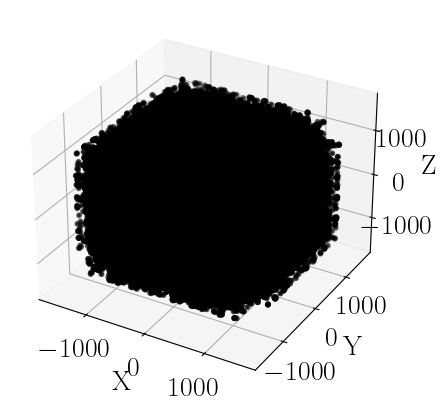

In [ ]:
# %matplotlib qt
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
voxelGrid = ax.scatter(grid_pos[:,0],
                       grid_pos[:,1],
                       grid_pos[:,2],  
                       c=grid[grid >= 0],
                       cmap='viridis',
                       marker='s',
                       alpha=0.01,
                       s=10,
                       norm=LogNorm())  # Use LogNorm for log scale
track_true = ax.scatter(np.array(df_primary['position'].to_list()).reshape(-1,3)[:,0],
                        np.array(df_primary['position'].to_list()).reshape(-1,3)[:,1],
                        np.array(df_primary['position'].to_list()).reshape(-1,3)[:,2],
                        c='black',
                        marker='o',
                        s=5,
                        linewidth=2)
track_reco_X = ax.scatter(pos_max[0],
                          pos_max[1],
                          pos_max[2],
                          c='r',
                          marker='o',
                          s=30,
                          label='X',
                          linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm())
sm.set_array(grid[grid > 0])
# ax.legend()
# cbar = fig.colorbar(sm, ax=ax, label='Color Bar (Log Scale)')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_43022/1041868959.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


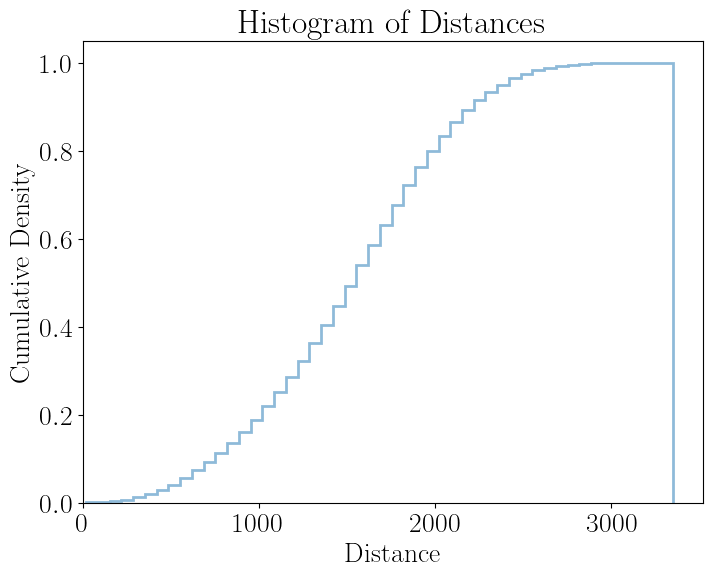

In [ ]:
# %matplotlib inline

true = np.array(df_primary['position'].to_list()).reshape(-1,3)
distances = cdist(true, np.reshape(pos_max, (1,3)))
distances = np.min(distances, axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
cum = True
ax.hist(distances, bins=50, alpha=0.5, label='avg', histtype='step', cumulative=cum, density=True, linewidth=2)
ax.set_xlabel('Distance')
ax.set_ylabel('Cumulative Density')
ax.set_title('Histogram of Distances')
ax.set_xlim(xmin=0)
# ax.legend()
fig.show()